## ASTR 598 Astrostatistics

## HW4 - Classification of QSO and Stars

### Dino Bektsevic, Meredith Durbin, Tyler Gordon, Joachim Moeyens, Brianna Thomas

The files for this notebook and the code to read them were generously provided by Group 2 (Chris Suberlak, Hayden Smotherman, Winnie Wang). These files are located on Joachim's [Google Drive](https://drive.google.com/drive/folders/1r3o2I9iK6nrSDbbXTBX-YJM81BzIvAbh) (link will be disabled after the quarter is over).

## Reading Data
- [Numpy and Astropy Tables](#Read-Data:-Numpy-and-Astropy-Tables)
- [Pandas and HDF5](#Read-Data:-Pandas-and-HDF5)

## Machine Learning Classifiers
- [Linear Discriminant Analysis](#Linear-Discriminant-Analysis)
- [Gaussian Mixture Models](#Gaussian-Mixture-Models)
- [Support Vector Machine](#Support-Vector-Machine)
- [The Fun Stuff](#Neural-Networks)
    - [Just Fun](#Single-Layer)
    - [Double the Fun](#Double-Layer)
    - [Too Much Fun](#Six-Layers)
    
Installing requirements:
``` pip install -r requirements.txt ```

In [1]:
import vaex
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from astropy.table import Table
from astropy.table import hstack

from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from astroML.classification import GMMBayes
from astroML.decorators import pickle_results
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
from astroML.plotting.tools import draw_ellipse

# The fun stuff
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras_tqdm import TQDMNotebookCallback

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', font_scale=1.2)

Using TensorFlow backend.


## Read Data: Numpy and Astropy Tables

In [2]:
# Load the QSO training sample
qso = Table(np.load('hlc_nsc_sdss_qso_matches.npy'))

# Load the standard stars training sample 
stars = Table(np.load('hlc_nsc_sdss_stars_matches.npy'))

In [3]:
#de-reddening apparent magnitudes based on 
def make_dereddened_colors(table):
    # Make column with HLC dereddened magnitudes 
    filters = 'ugriz'
    for f in filters : 
        table['HLC'+f+'mag_dered'] = table['HLC'+f+'mag'] - table['HLC'+f+'RED']

    # Make column with HLC colors based on dereddened magnitudes
    for i in range(len(filters)-1):
        f1,f2 = filters[i], filters[i+1]
        table['HLC'+f1+'-'+f2] = table['HLC'+f1+'mag_dered']-table['HLC'+f2+'mag_dered']
        
#make_dereddened_colors(hlc_nsc)
make_dereddened_colors(stars)
make_dereddened_colors(qso)

In [4]:
np.warnings.filterwarnings("ignore")

def fetch_dr14_quasars(qso):
    # SDSS DR14 QSO cross-matched to HLC-NSC catalog 
    # --> signal / noise > 5 
    m_g_sn = qso['HLCgmag'] / qso['HLCgerr'] > 5
    m_u_sn = qso['HLCumag'] / qso['HLCuerr'] > 5
    m_r_sn = qso['HLCrmag'] / qso['HLCrerr'] > 5
    m_redshift = qso['Z'] < 2.5

    m = m_g_sn * m_u_sn * m_r_sn  * m_redshift
    print('We select ', np.sum(m), ' of ', len(m))
    quasars = qso[m]
    return quasars

def fetch_standard_stars(stars):
    # STARS
    # --> signal / noise > 5 
    m_g_sn = stars['HLCgmag'] / stars['HLCgerr'] > 5
    m_u_sn = stars['HLCumag'] / stars['HLCuerr'] > 5
    m_r_sn = stars['HLCrmag'] / stars['HLCrerr'] > 5

    m =  m_g_sn * m_u_sn* m_r_sn
    print('We select ', np.sum(m), ' of ', len(m))
    stars = stars[m]
    return stars

quasars =  fetch_dr14_quasars(qso)
stars = fetch_standard_stars(stars)

# stack colors into matrix X : it is the training set 
# size : ( number of qso + number of stars ) * ( number of colors )
Nqso = len(quasars)
Nstars = len(stars)
X = np.empty((Nqso + Nstars, 4), dtype=float)

X[:Nqso, 0] = quasars['HLCu-g']
X[:Nqso, 1] = quasars['HLCg-r']
X[:Nqso, 2] = quasars['HLCr-i']
X[:Nqso, 3] = quasars['HLCi-z']

X[Nqso:, 0] = stars['HLCu-g']
X[Nqso:, 1] = stars['HLCg-r']
X[Nqso:, 2] = stars['HLCr-i']
X[Nqso:, 3] = stars['HLCi-z']

# Make a vector with labels 
y = np.zeros(Nqso + Nstars, dtype=int)
y[:Nqso] = 1  # 1 = qso ,  0 = star 

# split into training and test sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.9, 0.1],
                                                     random_state=0)

We select  7250  of  22205
We select  260872  of  693857


## Read Data: Pandas and HDF5

In [5]:
querystr = ' & '.join(['(HLC{}mag > HLC{}err * 5)'.format(f,f) for f in 'ugriz']) + '& (NSCclass_star > 0.5)'
#querystr += ' & (NSCclass_star > 0.5) & (HLCgmag > HLCgerr * 5) & (HLCrmag > HLCrerr * 5)'
df_s = pd.read_hdf('hlc_nsc_sdss_stars_matches.hdf5', key='data').query(querystr)
df_q = pd.read_hdf('hlc_nsc_sdss_qso_matches.hdf5', key='data').query(querystr)
df_s = df_s.assign(star_or_quasar = 0)
df_q = df_q.assign(star_or_quasar = 1)
df = pd.concat([df_s, df_q], ignore_index=True)

Text(0.5,64,'u-g')

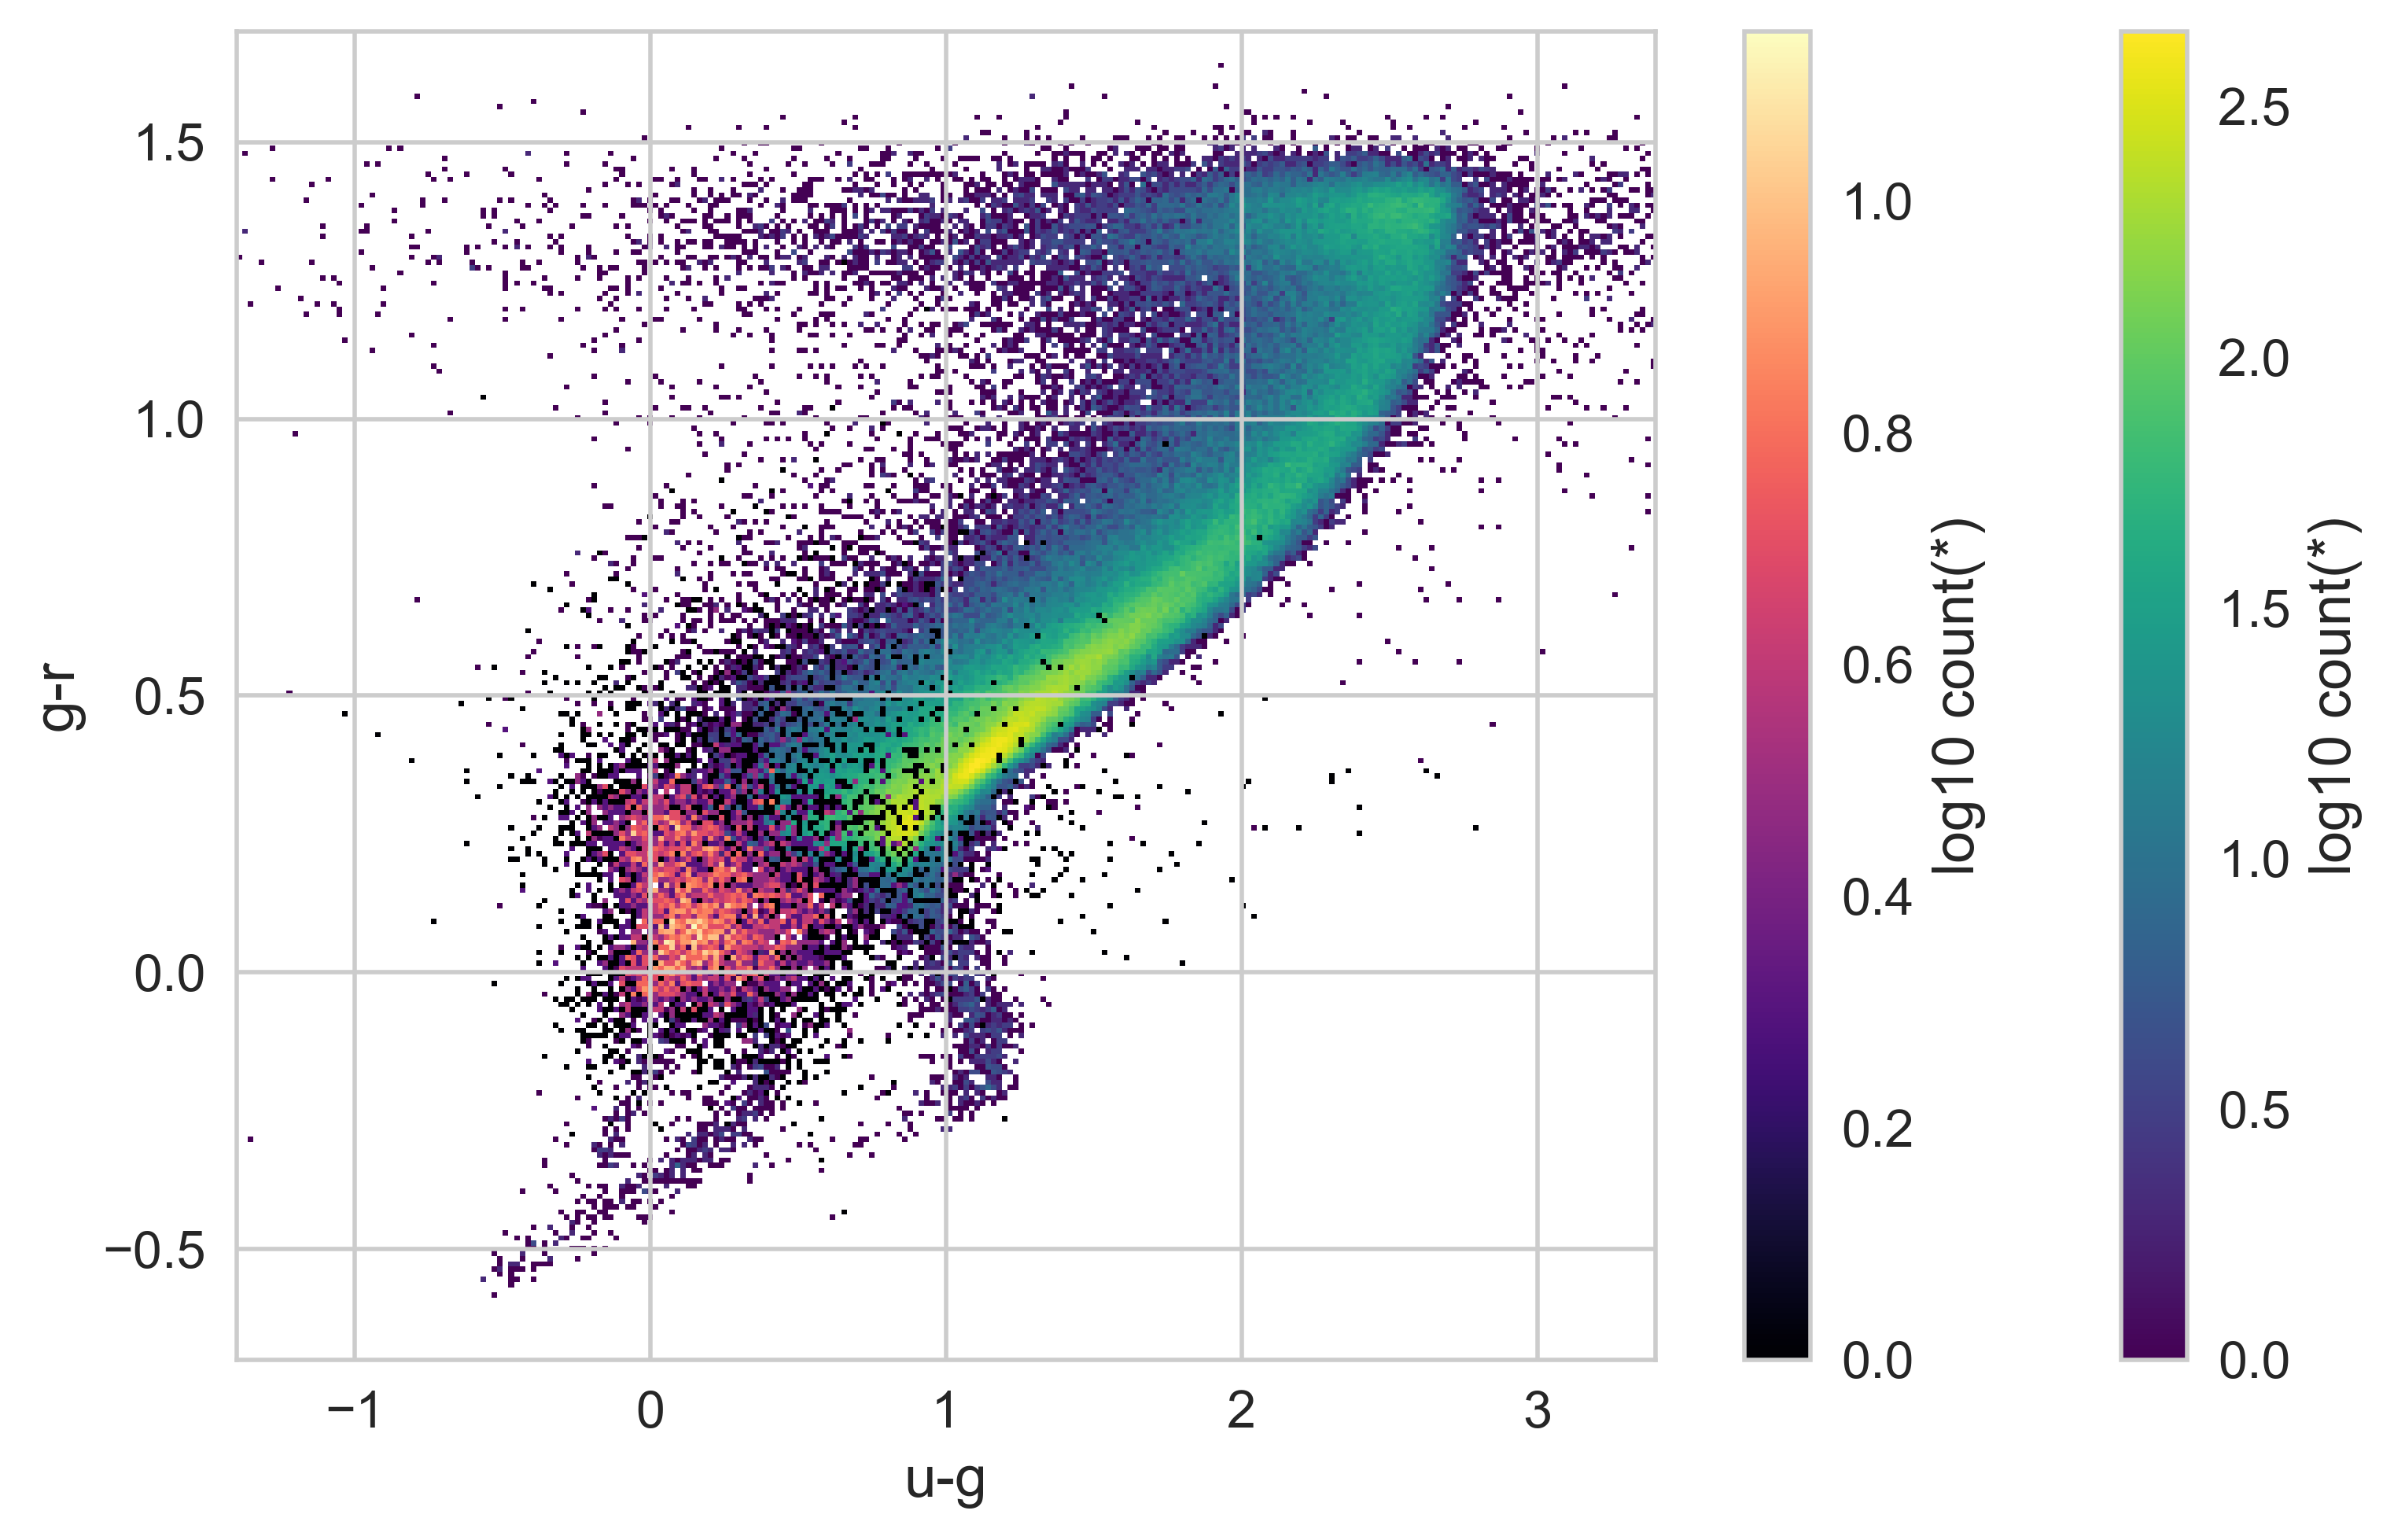

In [6]:
fig, ax = plt.subplots(1, figsize=(8,5), dpi=200)
lim = [[-1.4,3.4], [-0.7,1.7]]
vaex.from_pandas(df_s).plot('HLC_u_g', 'HLC_g_r', f='log10', limits=lim, colormap='viridis')
vaex.from_pandas(df_q).plot('HLC_u_g', 'HLC_g_r', f='log10', limits=lim, colormap='magma')
ax.set_xlim(lim[0])
ax.set_ylim(lim[1])
ax.set_ylabel("g-r")
ax.set_xlabel("u-g")

## Linear Discriminant Analysis 

Uses HDF5 files.

In [7]:
df_train = df.sample(int(df.shape[0]/10))
df_test = df[~df.index.isin(df_train.index)]

colors = 'HLC_u_g','HLC_g_r','HLC_r_i','HLC_i_z'
X_hdf5 = df_train[[*colors]].values
y_hdf5 = df_train.star_or_quasar.values

X_test_hdf5 = df_test[[*colors]].values
y_test_hdf5 = df_test.star_or_quasar.values

solvers = ['svd','eigen']
linestyles = ['-',':']
colors = ['k', 'grey']
y_scores_hdf5 = []
for solver, ls, c in zip(solvers, linestyles, colors):
    lda = LinearDiscriminantAnalysis(solver=solver, store_covariance=True)
    lda_fit = lda.fit(X_hdf5, y_hdf5)
    y_score_hdf5 = lda_fit.predict_proba(X_test_hdf5)
    y_scores_hdf5.append(y_score_hdf5[:,1])

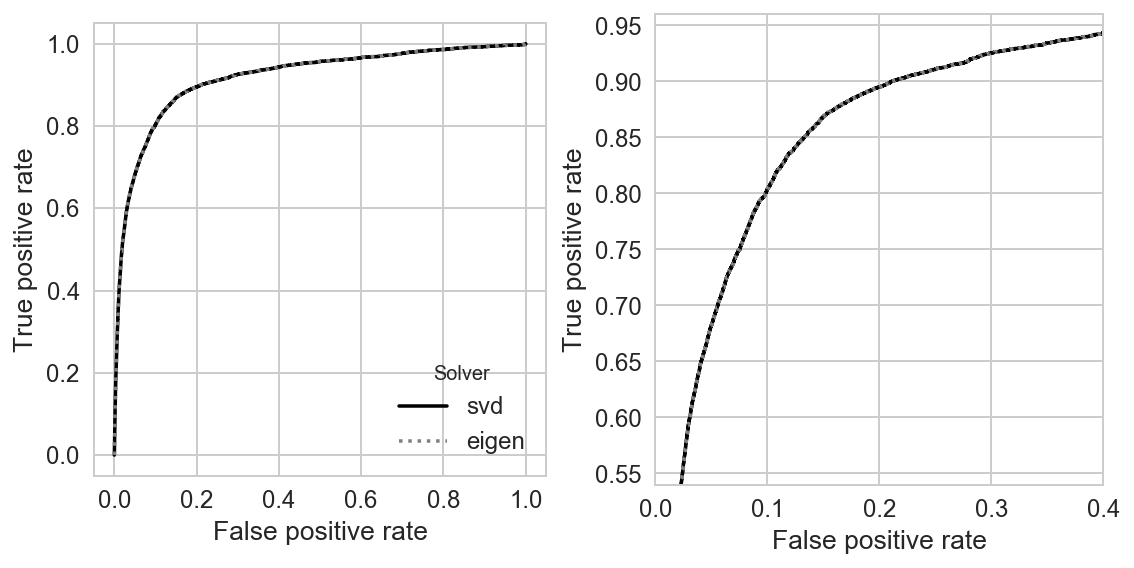

In [8]:
fig, (ax, ax1) = plt.subplots(1,2,figsize=(8,4))
ax.set_aspect('equal')
ax1.set_aspect('equal')
ax1.set_xlim(0,0.4)
ax1.set_ylim(0.54,0.96)
#ax1.set_yticks([0.75,0.8,0.85,0.9,0.95])

for y_score, solver, ls, c in zip(y_scores_hdf5, solvers, linestyles, colors):
    fpr, tpr, thresholds = roc_curve(y_test_hdf5, y_score)
    ax.plot(fpr, tpr, label=solver, color=c, ls=ls)
    ax1.plot(fpr, tpr, label=solver, color=c, ls=ls)
ax.legend(title='Solver')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
fig.tight_layout()

## Gaussian Mixture Models

Uses numpy npy files.

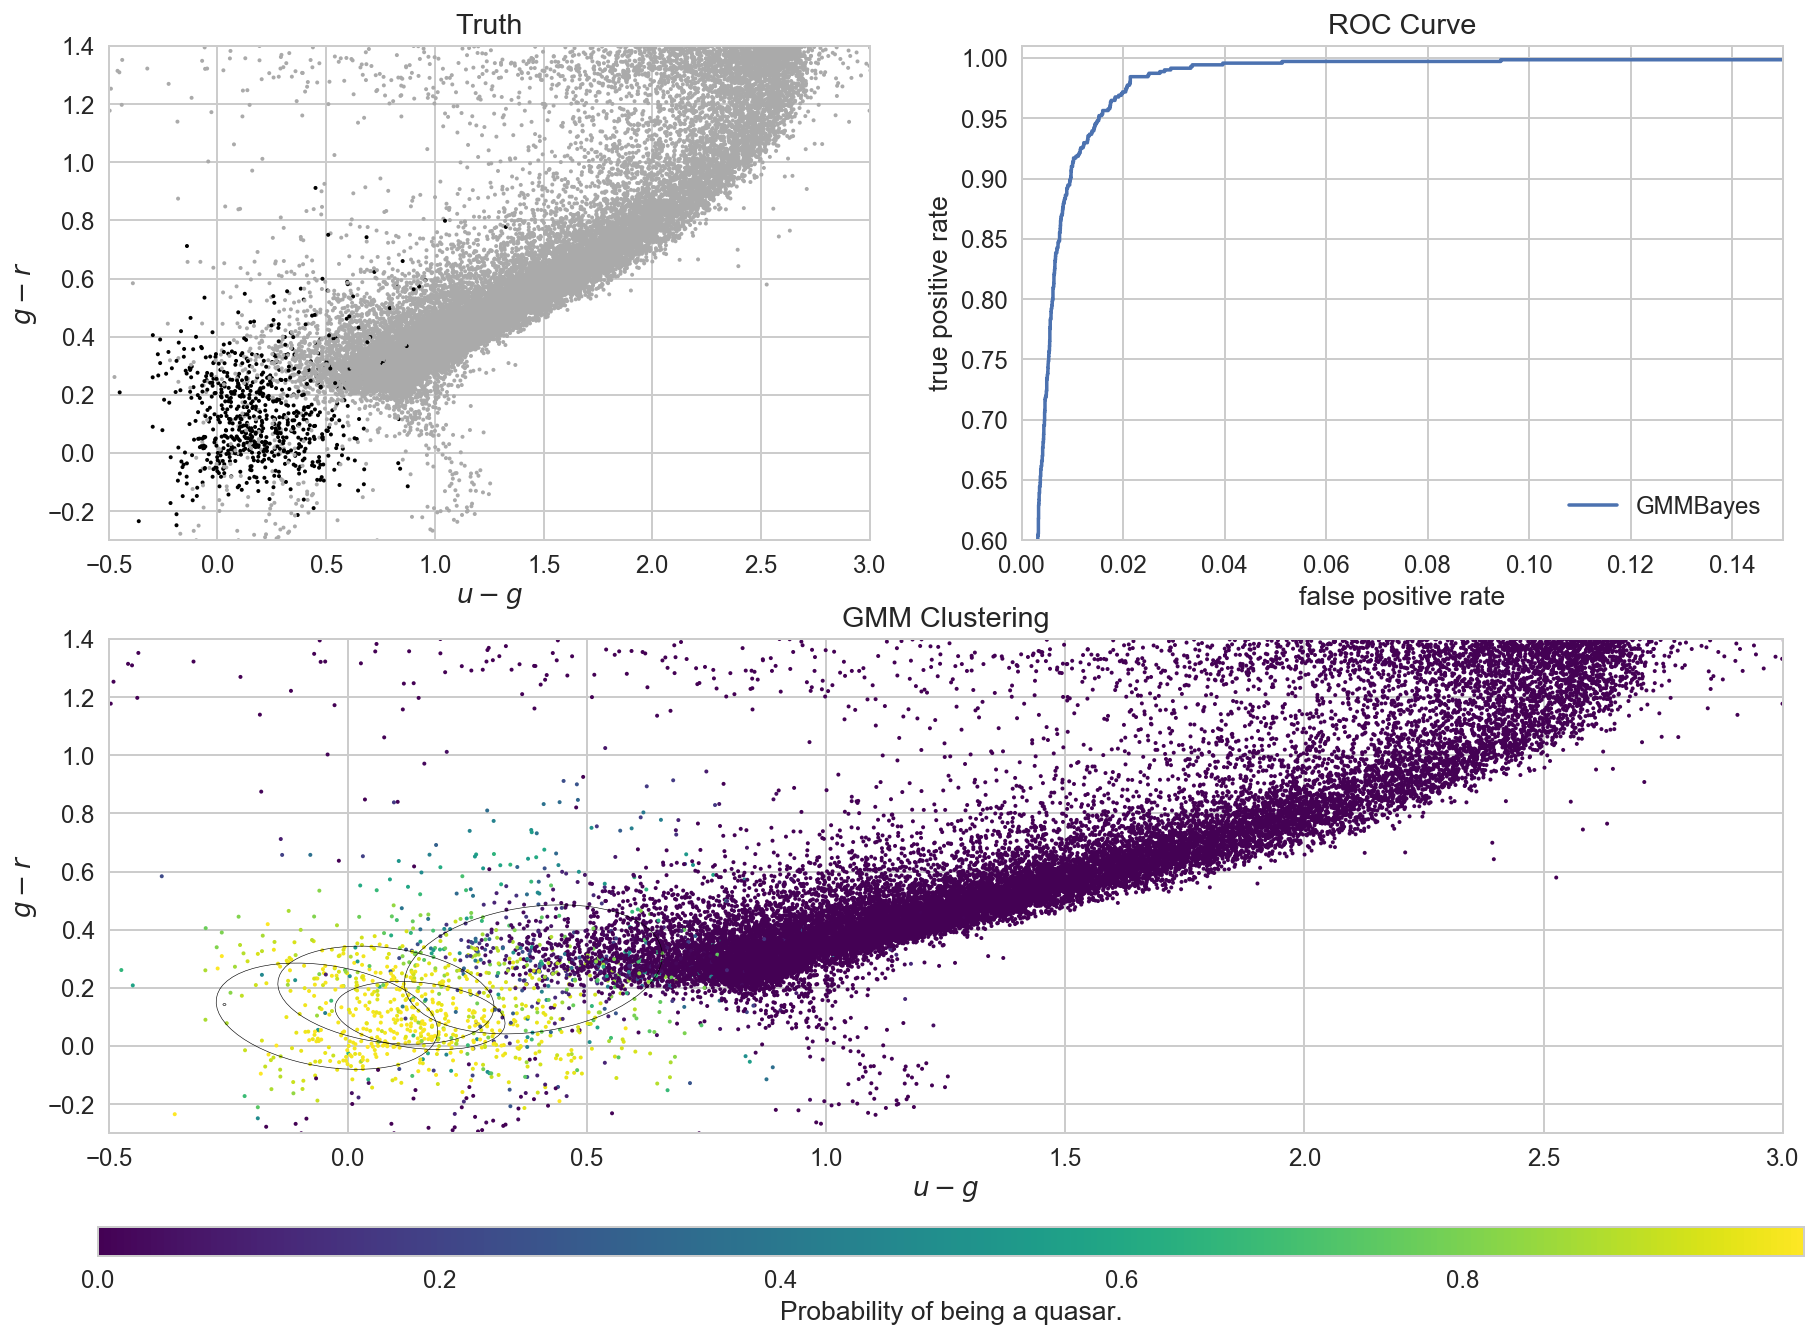

In [9]:
classifier = GMMBayes(n_components=5, min_covar=1e-5, covariance_type='full')
classifier.fit(X_train, y_train)

predictions = classifier.predict_proba(X_test)
y_prob = predictions[:, 1]

plt.figure(figsize=(15,10))

# Plot data
ax = plt.subplot(221)

im = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=4, linewidths=0, edgecolors='none', cmap=plt.cm.binary)
im.set_clim(-0.5, 1)

ax.set_xlim(-0.5, 3.0)
ax.set_ylim(-0.3, 1.4)
ax.set_xlabel('$u - g$')
ax.set_ylabel('$g - r$')
ax.set_title("Truth")


# Plot ROC
ax = plt.subplot(222)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
ax.plot(fpr, tpr, label="GMMBayes")

ax.legend(loc=4)
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_xlim(0, 0.15)
ax.set_ylim(0.6, 1.01)
ax.set_title("ROC Curve")


# Plot predictions
ax = plt.subplot(212)

im = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_prob, s=4, edgecolors="None", cmap="viridis")
ax.set_xlim(-0.5, 3.0)
ax.set_ylim(-0.3, 1.4)
ax.set_xlabel('$u - g$')
ax.set_ylabel('$g - r$')
ax.set_title("GMM Clustering")

#which gmms is it?
for i in range(classifier.n_components[0]):
    mean = classifier.gmms_[1].means_[i]
    cov = classifier.gmms_[1].covars_[i]
    if cov.ndim == 1:
        cov = np.diag(cov)
    draw_ellipse(mean, cov, ax=plt.gca(), scales=[1], fc='none', ec='black', zorder=2)

# colorbars man....
cbar_ax = plt.gcf().add_axes(([0.12, 0.04, 0.79, 0.02]))
plt.colorbar(im, cax=cbar_ax, orientation="horizontal", label="Probability of being a quasar.")

plt.show()

### Get classification correctness per color dimension

completeness [ 0.62640449  0.66994382  0.84129213  0.9002809 ]
contamination [ 0.35642136  0.25352113  0.21391076  0.28219485]


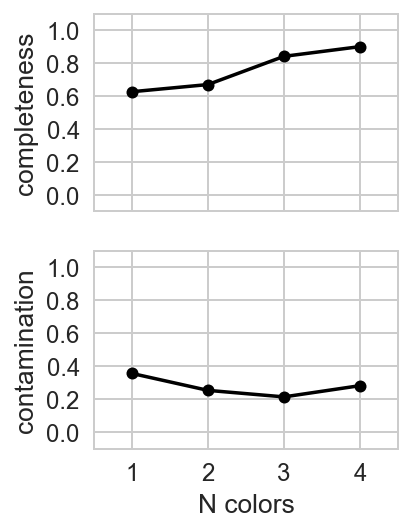

In [10]:
classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

for nc in Ncolors:
    clf = GMMBayes(n_components=5, min_covar=1E-5, covariance_type='full')
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

# Plot completeness vs Ncolors
ax = plt.subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# Plot contamination vs Ncolors
ax = plt.subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)
plt.show()

### Classification correctness per number of components

completeness [ 0.28230337  0.78932584  0.7752809   0.76544944  0.9002809   0.91151685
  0.89606742  0.88623596  0.86938202  0.89044944  0.87359551  0.88202247
  0.875       0.89466292]
contamination [ 0.39820359  0.50133097  0.34128878  0.22804533  0.28139013  0.27808676
  0.2572759   0.24158654  0.19401042  0.20251572  0.20051414  0.19693095
  0.19716495  0.19874214]


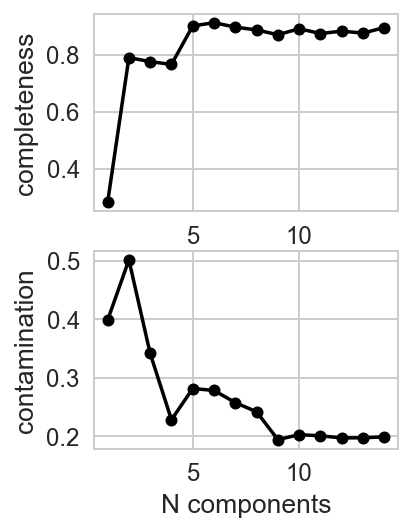

In [11]:
predictions = []
classifiers = []
Ncomponents = range(1, 15)

for nc in Ncomponents:
    clf = GMMBayes(n_components=nc, min_covar=1E-5, covariance_type='full')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    classifiers.append(clf)
    predictions.append(y_pred)
    
completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

# Plot completeness vs Ncomponents
ax = plt.subplot(222)
ax.plot(Ncomponents, completeness, 'o-k', ms=6)

ax.set_ylabel('completeness')
ax.grid(True)

# Plot contamination vs Ncomponents
ax = plt.subplot(224)
ax.plot(Ncomponents, contamination, 'o-k', ms=6)

ax.set_xlabel('N components')
ax.set_ylabel('contamination')
ax.grid(True)

plt.show()

## Support Vector Machine

Uses numpy npy files.

@pickle_results: computing results and saving to 'SVM_qso.pkl'
completeness [ 0.95786517  0.95505618  0.95505618  0.95365169]
contamination [ 0.66764133  0.63063552  0.61840629  0.6183249 ]


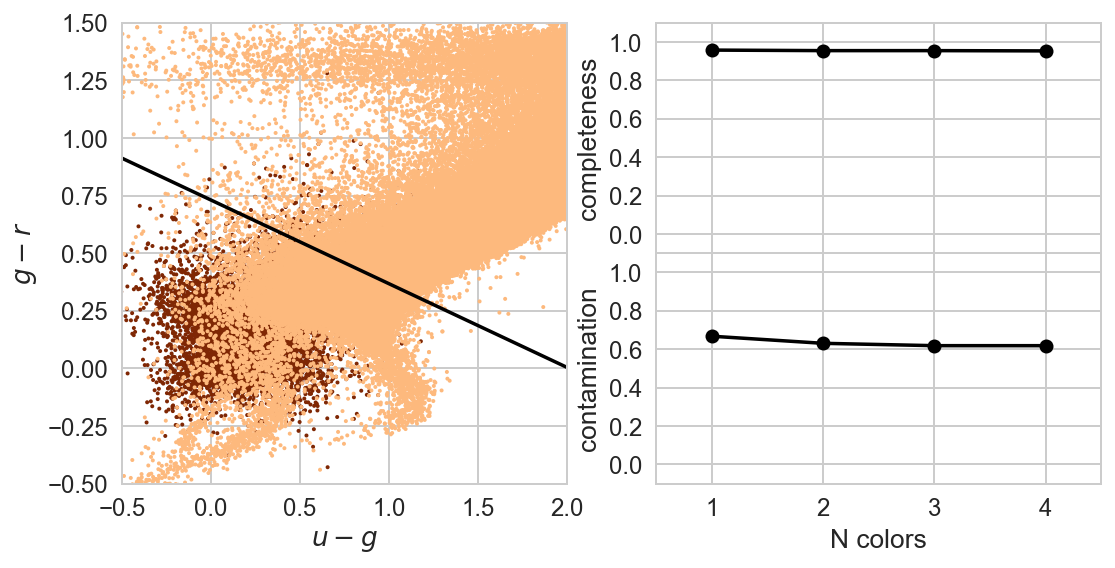

In [13]:
N_tot = len(y)
N_st = np.sum(y == 0)
N_qso = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)

#----------------------------------------------------------------------
# Fit SVM
Ncolors = np.arange(1, X.shape[1] + 1)

@pickle_results('SVM_qso.pkl')
def compute_SVM(Ncolors):
    classifiers = []
    predictions = []

    for nc in Ncolors:
        # perform support vector classification
        clf = SVC(kernel='linear', class_weight='balanced')
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers.append(clf)
        predictions.append(y_pred)

    return classifiers, predictions

classifiers, predictions = compute_SVM(Ncolors)

completeness, contamination = completeness_contamination(predictions, y_test)

print ("completeness", completeness)
print ("contamination", contamination)

#------------------------------------------------------------
# compute the decision boundary
clf = classifiers[1]
w = clf.coef_[0]
a = -w[0] / w[1]
yy = np.linspace(0, 1)
xx = a * yy - clf.intercept_[0] / w[1]

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
ax.plot(xx, yy, '-k')
im = ax.scatter(X[:, 0], X[:, 1], c=y,
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)
ax.set_xlim(-0.5, 2.0)
ax.set_ylim(-0.5, 1.5)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness, 'o-k')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

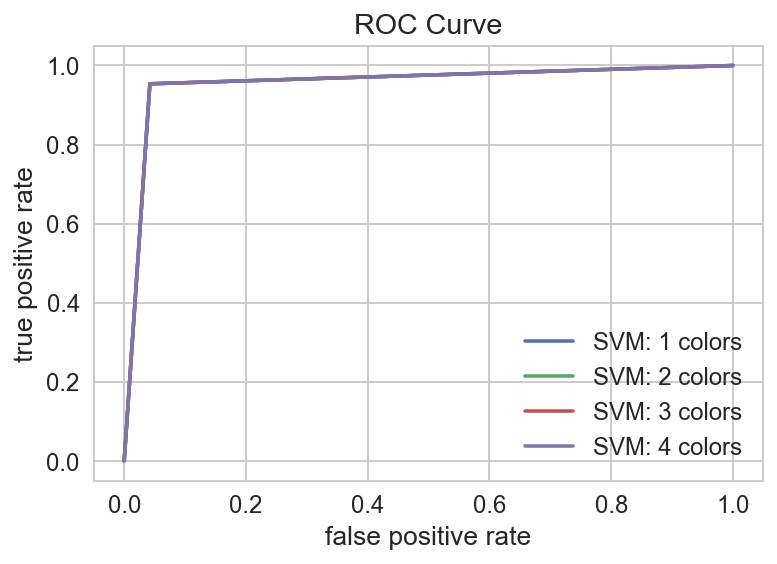

In [25]:
ax = plt.subplot(111)

for i, pred in enumerate(predictions):

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    ax.plot(fpr, tpr, label="SVM: {} colors".format(i+1))

ax.legend(loc=4);
ax.set_xlabel('false positive rate');
ax.set_ylabel('true positive rate');
ax.set_title("ROC Curve");

## Neural Networks

Uses numpy npy files.

In [26]:
# Need to get in shape
Y_train = np_utils.to_categorical(y_train, num_classes=2)
Y_test = np_utils.to_categorical(y_test, num_classes=2)

### Single Layer

In [27]:
# Start simple: one layer: 
# 2 fully interconnected nodes with softmax activation
model = Sequential()
model.add(Dense(2, input_dim=X_train.shape[1]))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 10        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [28]:
batch_size = 256
nb_epoch = 5

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    nb_epoch=nb_epoch,
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    callbacks=[TQDMNotebookCallback()])
score, accuracy = model.evaluate(X_test, Y_test, verbose=1)
print('Test score: {}; test accuracy: {}'.format(score, accuracy))

Train on 241309 samples, validate on 26813 samples


HBox(children=(IntProgress(value=0, description='Training', max=5), HTML(value='')))

Epoch 1/5


HBox(children=(IntProgress(value=0, description='Epoch 0', max=241309), HTML(value='')))

241309/241309 [==============================] - 2s 7us/step - loss: 0.2382 - acc: 0.9124 - val_loss: 0.0770 - val_acc: 0.9723
Epoch 2/5


HBox(children=(IntProgress(value=0, description='Epoch 1', max=241309), HTML(value='')))

241309/241309 [==============================] - 2s 7us/step - loss: 0.0667 - acc: 0.9720 - val_loss: 0.0580 - val_acc: 0.9730
Epoch 3/5


HBox(children=(IntProgress(value=0, description='Epoch 2', max=241309), HTML(value='')))

241309/241309 [==============================] - 2s 7us/step - loss: 0.0531 - acc: 0.9753 - val_loss: 0.0505 - val_acc: 0.9770
Epoch 4/5


HBox(children=(IntProgress(value=0, description='Epoch 3', max=241309), HTML(value='')))

241309/241309 [==============================] - 2s 7us/step - loss: 0.0484 - acc: 0.9795 - val_loss: 0.0481 - val_acc: 0.9796
Epoch 5/5


HBox(children=(IntProgress(value=0, description='Epoch 4', max=241309), HTML(value='')))

241309/241309 [==============================] - 2s 7us/step - loss: 0.0468 - acc: 0.9812 - val_loss: 0.0473 - val_acc: 0.9809

26813/26813 [==============================] - 0s 17us/step
Test score: 0.04726056936900867; test accuracy: 0.9808674896505426


268122/268122 [==============================] - 3s 9us/step


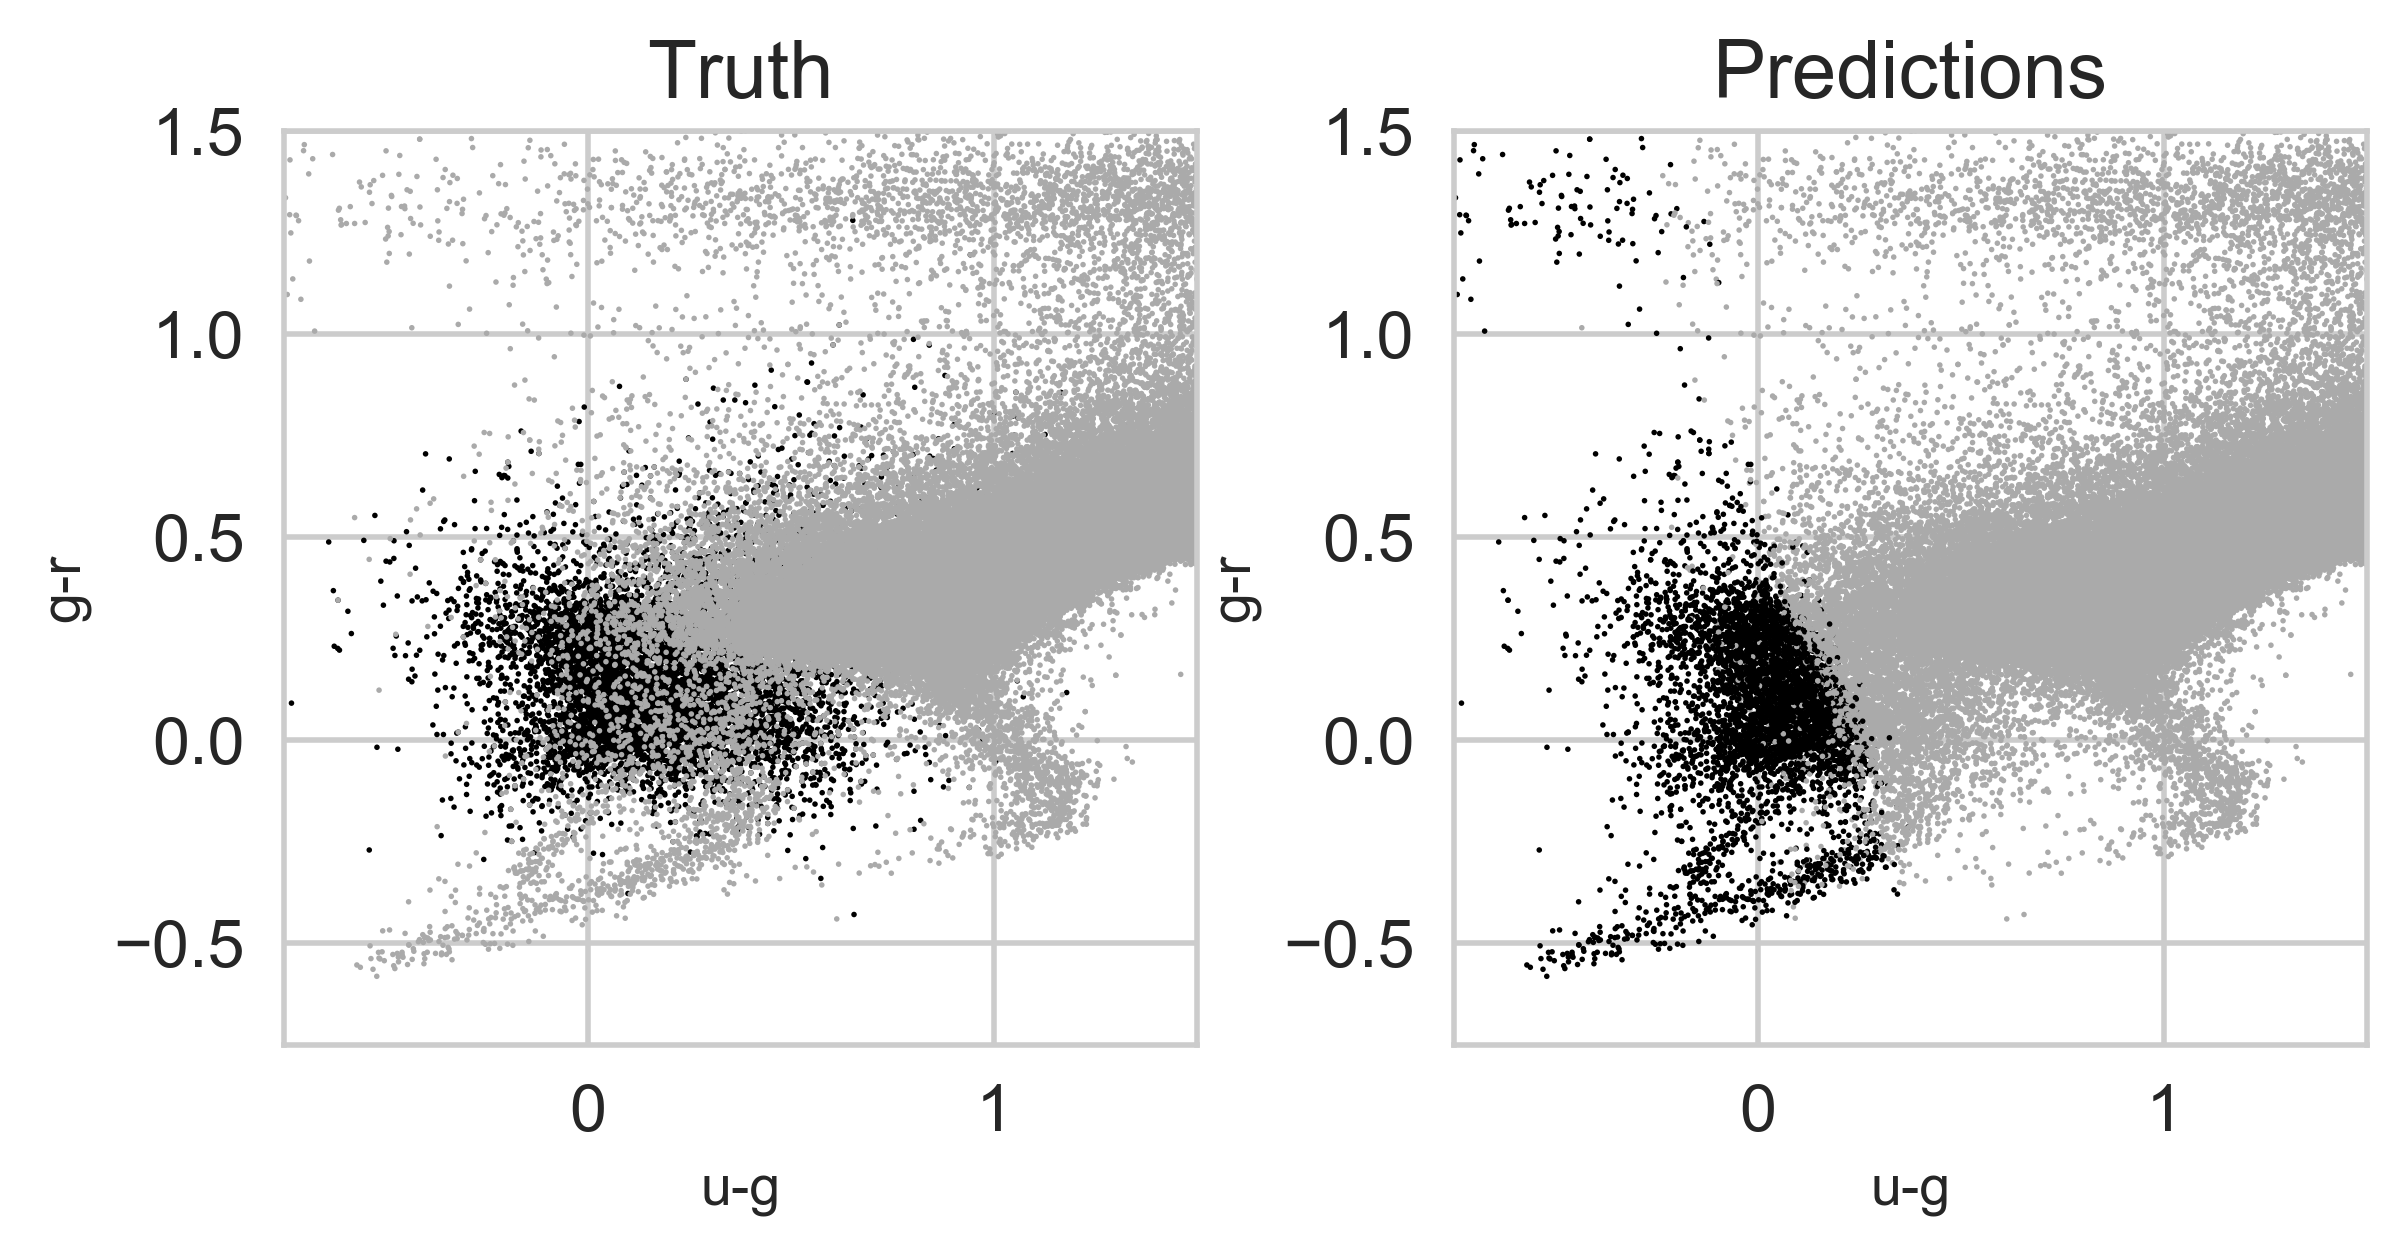

In [29]:
y_pred = model.predict_proba(X)
pred_test = model.predict_classes(X, verbose=1)

fig, ax = plt.subplots(1, 2, dpi=200)
fig.tight_layout()
im = ax[0].scatter(X[:, 0], X[:, 1], c=y, s=1, edgecolors="None",  cmap=plt.cm.binary)
im.set_clim(-0.5, 1)
im = ax[1].scatter(X[:, 0], X[:, 1], c=pred_test, s=1, edgecolors="None", cmap=plt.cm.binary)
im.set_clim(-0.5, 1)

ax[0].set_title("Truth")
ax[1].set_title("Predictions")


for a in ax:
    a.set_xlabel("u-g", size=10);
    a.set_ylabel("g-r", size=10);
    a.set_aspect("equal");
    a.set_xlim(-0.75, 1.5);
    a.set_ylim(-0.75, 1.5);

268122/268122 [==============================] - 3s 10us/step


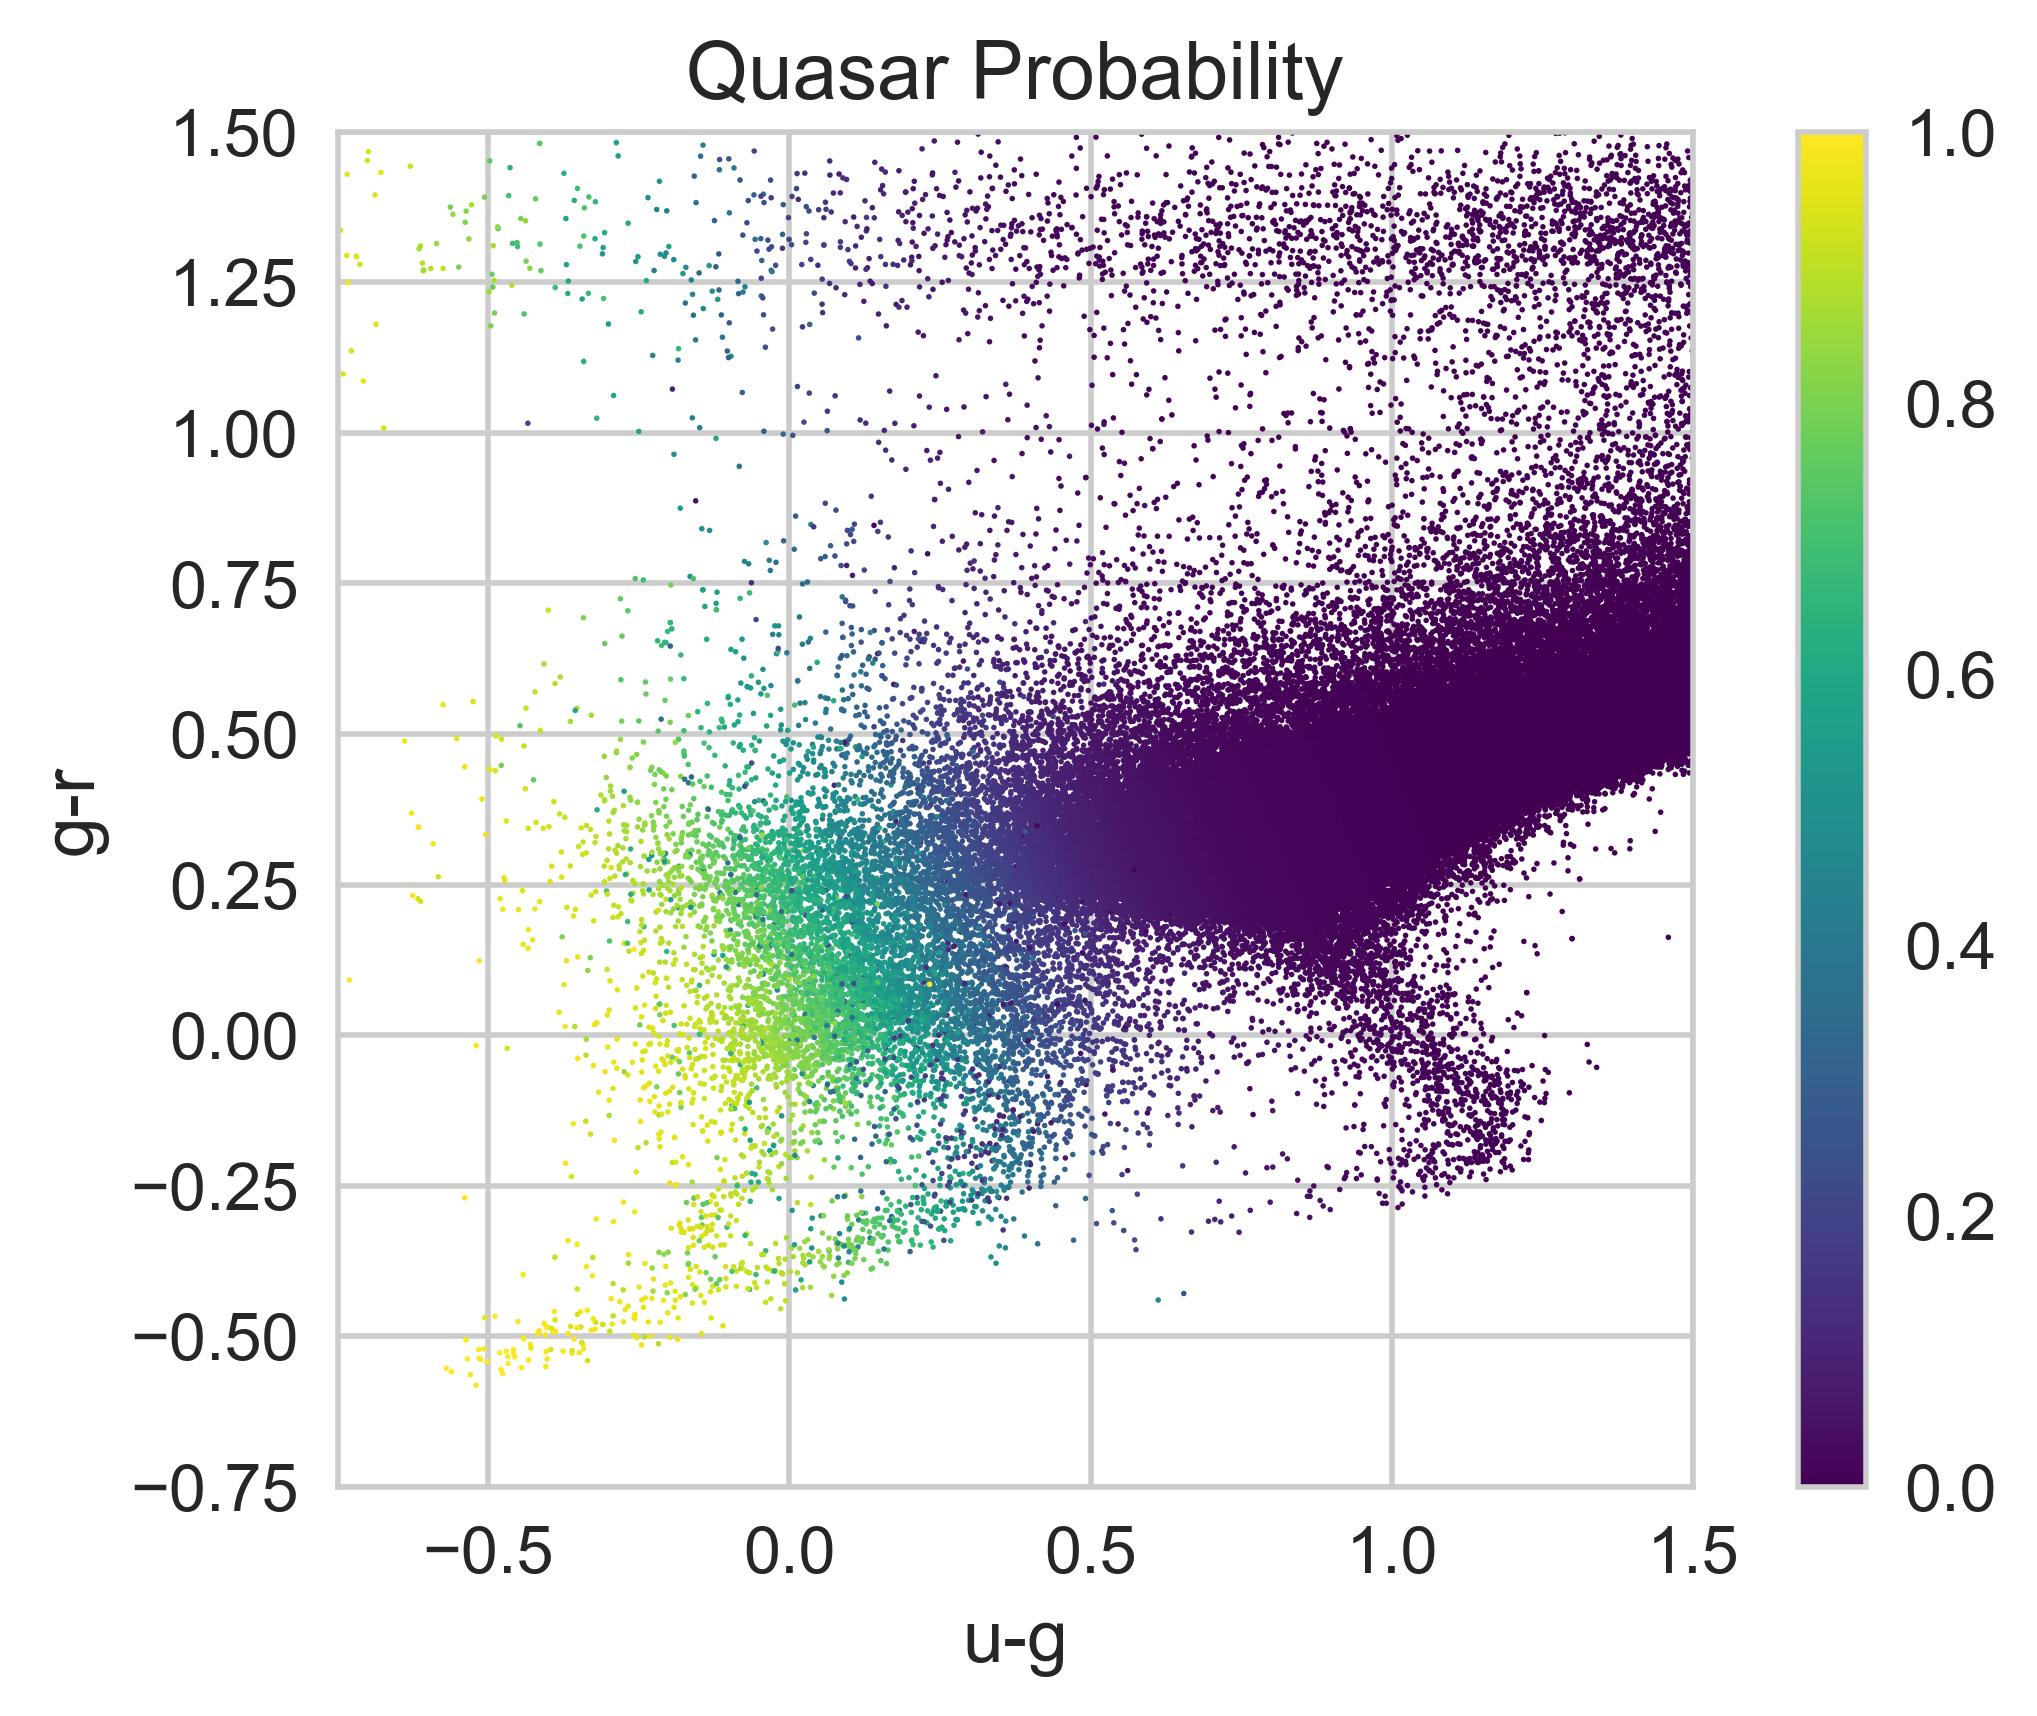

In [30]:
y_pred = model.predict_proba(X, verbose=1)

fig, ax = plt.subplots(1, 1, dpi=200)
fig.tight_layout()
cm = ax.scatter(X[:, 0], X[:, 1], c=y_pred[:, 1], s=1, edgecolors="None", cmap="viridis")
ax.set_xlabel("u-g");
ax.set_ylabel("g-r");
ax.set_aspect("equal");
ax.set_xlim(-0.75, 1.5);
ax.set_ylim(-0.75, 1.5);
ax.set_title("Quasar Probability");
fig.colorbar(cm);

### Double Layer

In [35]:
# Little bit more complicated: two layers: 
# 16 fully interconnected nodes with relu activation
# 2 fully interconnected nodes with softmax activation

model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                80        
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    nb_epoch=nb_epoch,
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    callbacks=[TQDMNotebookCallback()])
score, accuracy = model.evaluate(X_test, Y_test, verbose=1)
print('Test score: {}; test accuracy: {}'.format(score, accuracy))

Train on 241309 samples, validate on 26813 samples


HBox(children=(IntProgress(value=0, description='Training', max=5), HTML(value='')))

Epoch 1/5


HBox(children=(IntProgress(value=0, description='Epoch 0', max=241309), HTML(value='')))

241309/241309 [==============================] - 2s 8us/step - loss: 0.0767 - acc: 0.9778 - val_loss: 0.0412 - val_acc: 0.9830
Epoch 2/5


HBox(children=(IntProgress(value=0, description='Epoch 1', max=241309), HTML(value='')))

241309/241309 [==============================] - 2s 8us/step - loss: 0.0370 - acc: 0.9865 - val_loss: 0.0363 - val_acc: 0.9868
Epoch 3/5


HBox(children=(IntProgress(value=0, description='Epoch 2', max=241309), HTML(value='')))

241309/241309 [==============================] - 2s 8us/step - loss: 0.0340 - acc: 0.9881 - val_loss: 0.0345 - val_acc: 0.9880
Epoch 4/5


HBox(children=(IntProgress(value=0, description='Epoch 3', max=241309), HTML(value='')))

241309/241309 [==============================] - 2s 9us/step - loss: 0.0327 - acc: 0.9887 - val_loss: 0.0340 - val_acc: 0.9883
Epoch 5/5


HBox(children=(IntProgress(value=0, description='Epoch 4', max=241309), HTML(value='')))

241309/241309 [==============================] - 2s 9us/step - loss: 0.0321 - acc: 0.9891 - val_loss: 0.0334 - val_acc: 0.9885

26813/26813 [==============================] - 1s 20us/step
Test score: 0.03344534239959758; test accuracy: 0.9885130347019564


268122/268122 [==============================] - 3s 9us/step


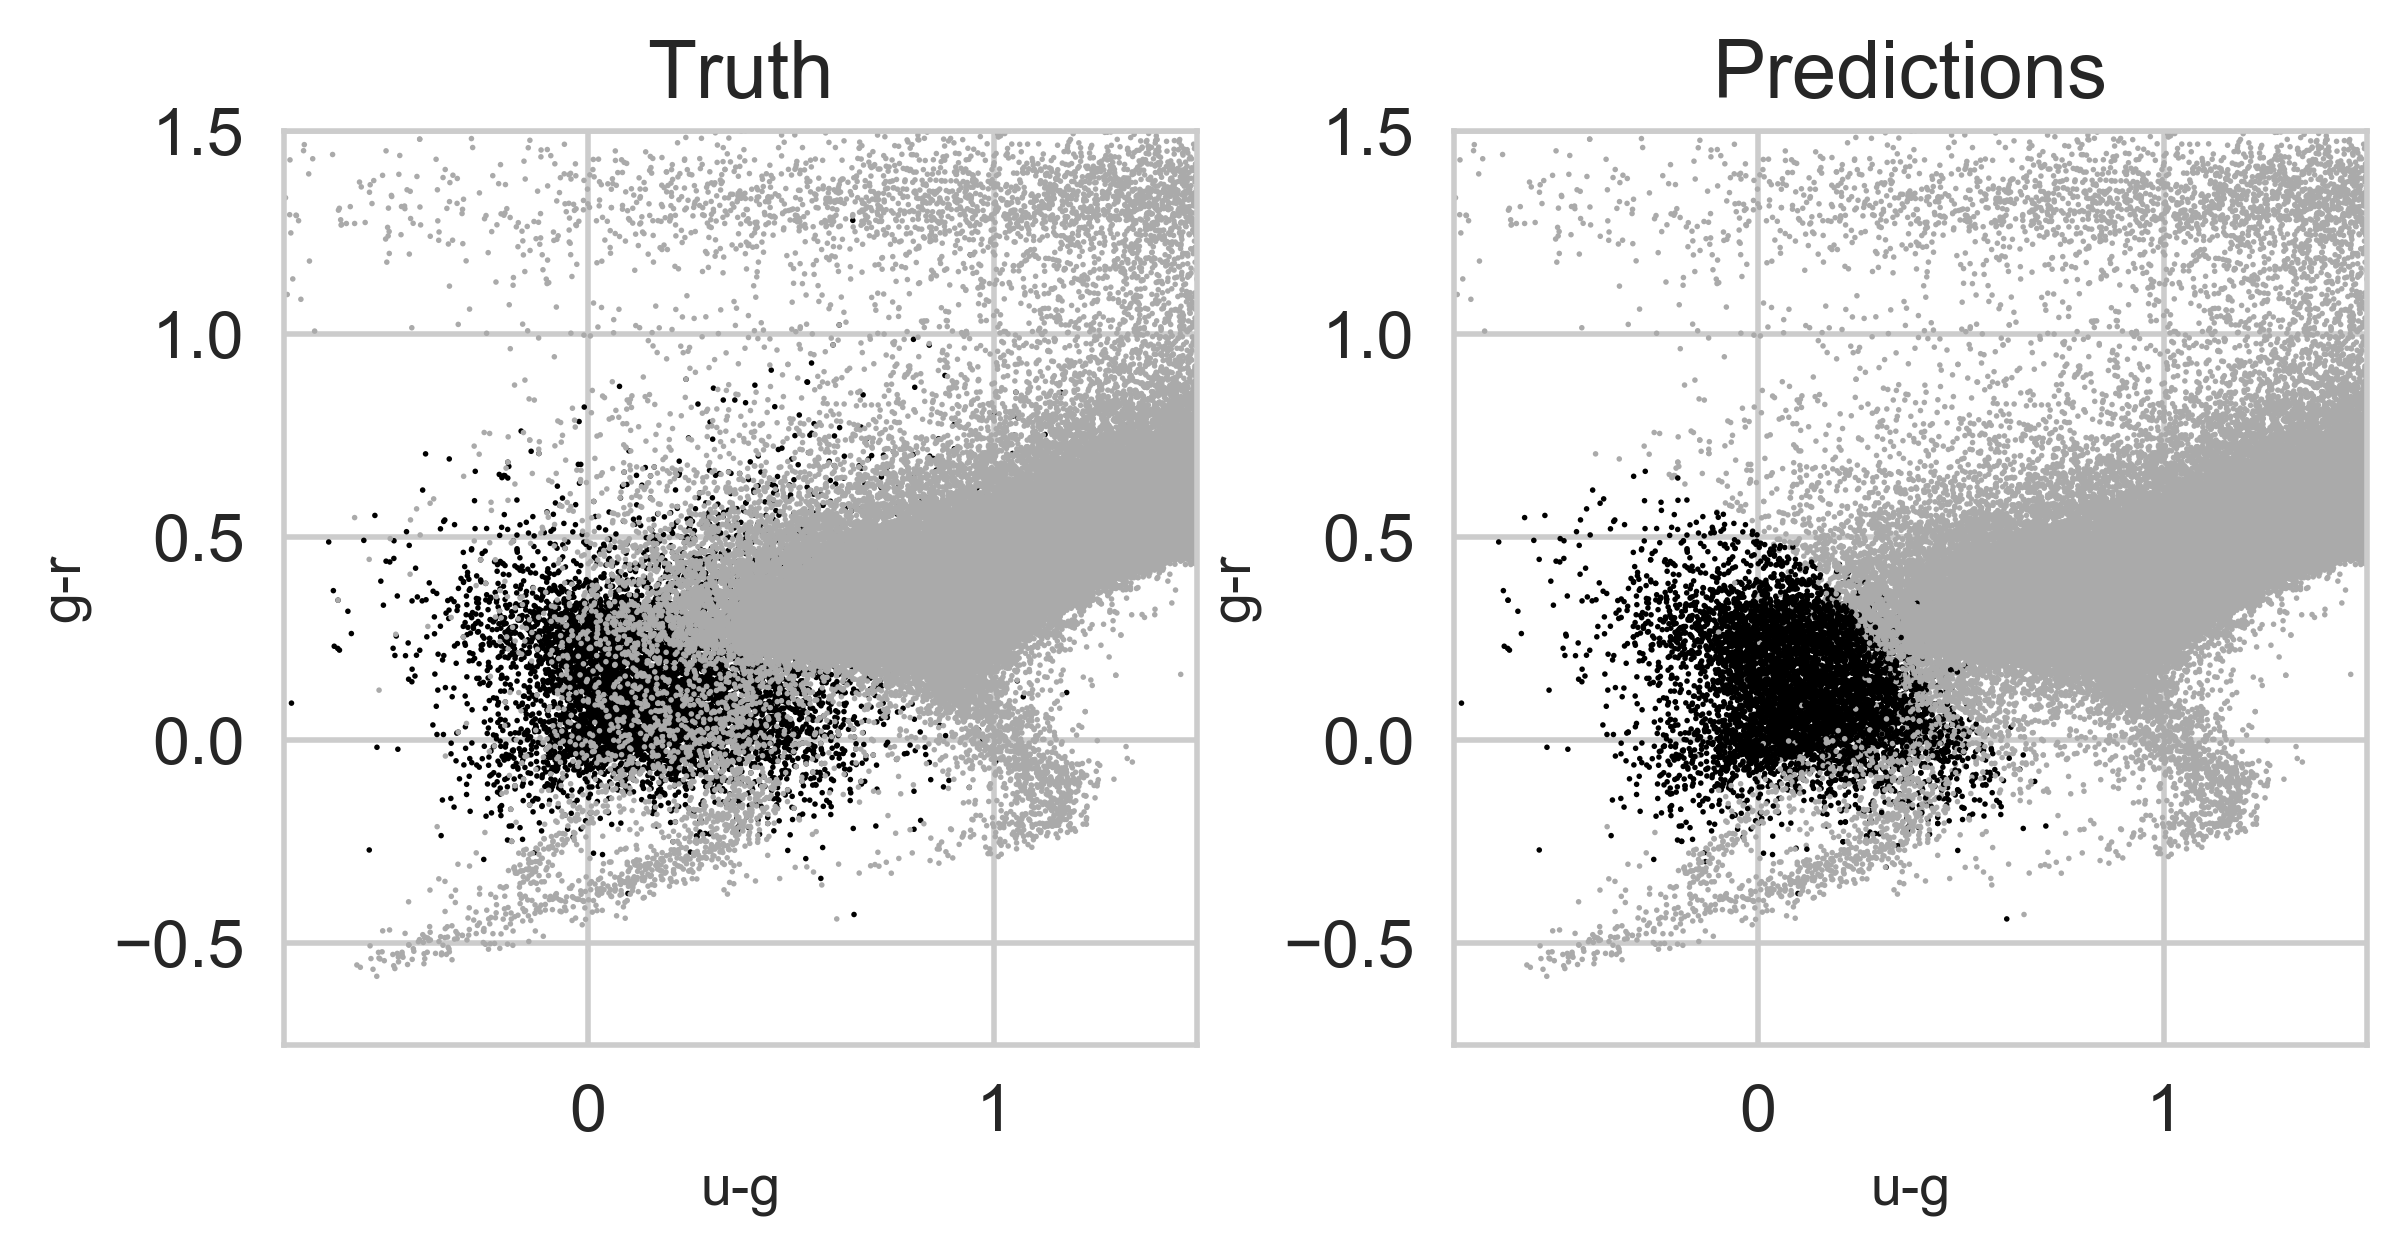

In [37]:
y_pred = model.predict_proba(X)
pred_test = model.predict_classes(X, verbose=1)

fig, ax = plt.subplots(1, 2, dpi=200)
fig.tight_layout()
im = ax[0].scatter(X[:, 0], X[:, 1], c=y, s=1, edgecolors="None",  cmap=plt.cm.binary)
im.set_clim(-0.5, 1)
im = ax[1].scatter(X[:, 0], X[:, 1], c=pred_test, s=1, edgecolors="None", cmap=plt.cm.binary)
im.set_clim(-0.5, 1)

ax[0].set_title("Truth")
ax[1].set_title("Predictions")


for a in ax:
    a.set_xlabel("u-g", size=10);
    a.set_ylabel("g-r", size=10);
    a.set_aspect("equal");
    a.set_xlim(-0.75, 1.5);
    a.set_ylim(-0.75, 1.5);

268122/268122 [==============================] - 3s 11us/step


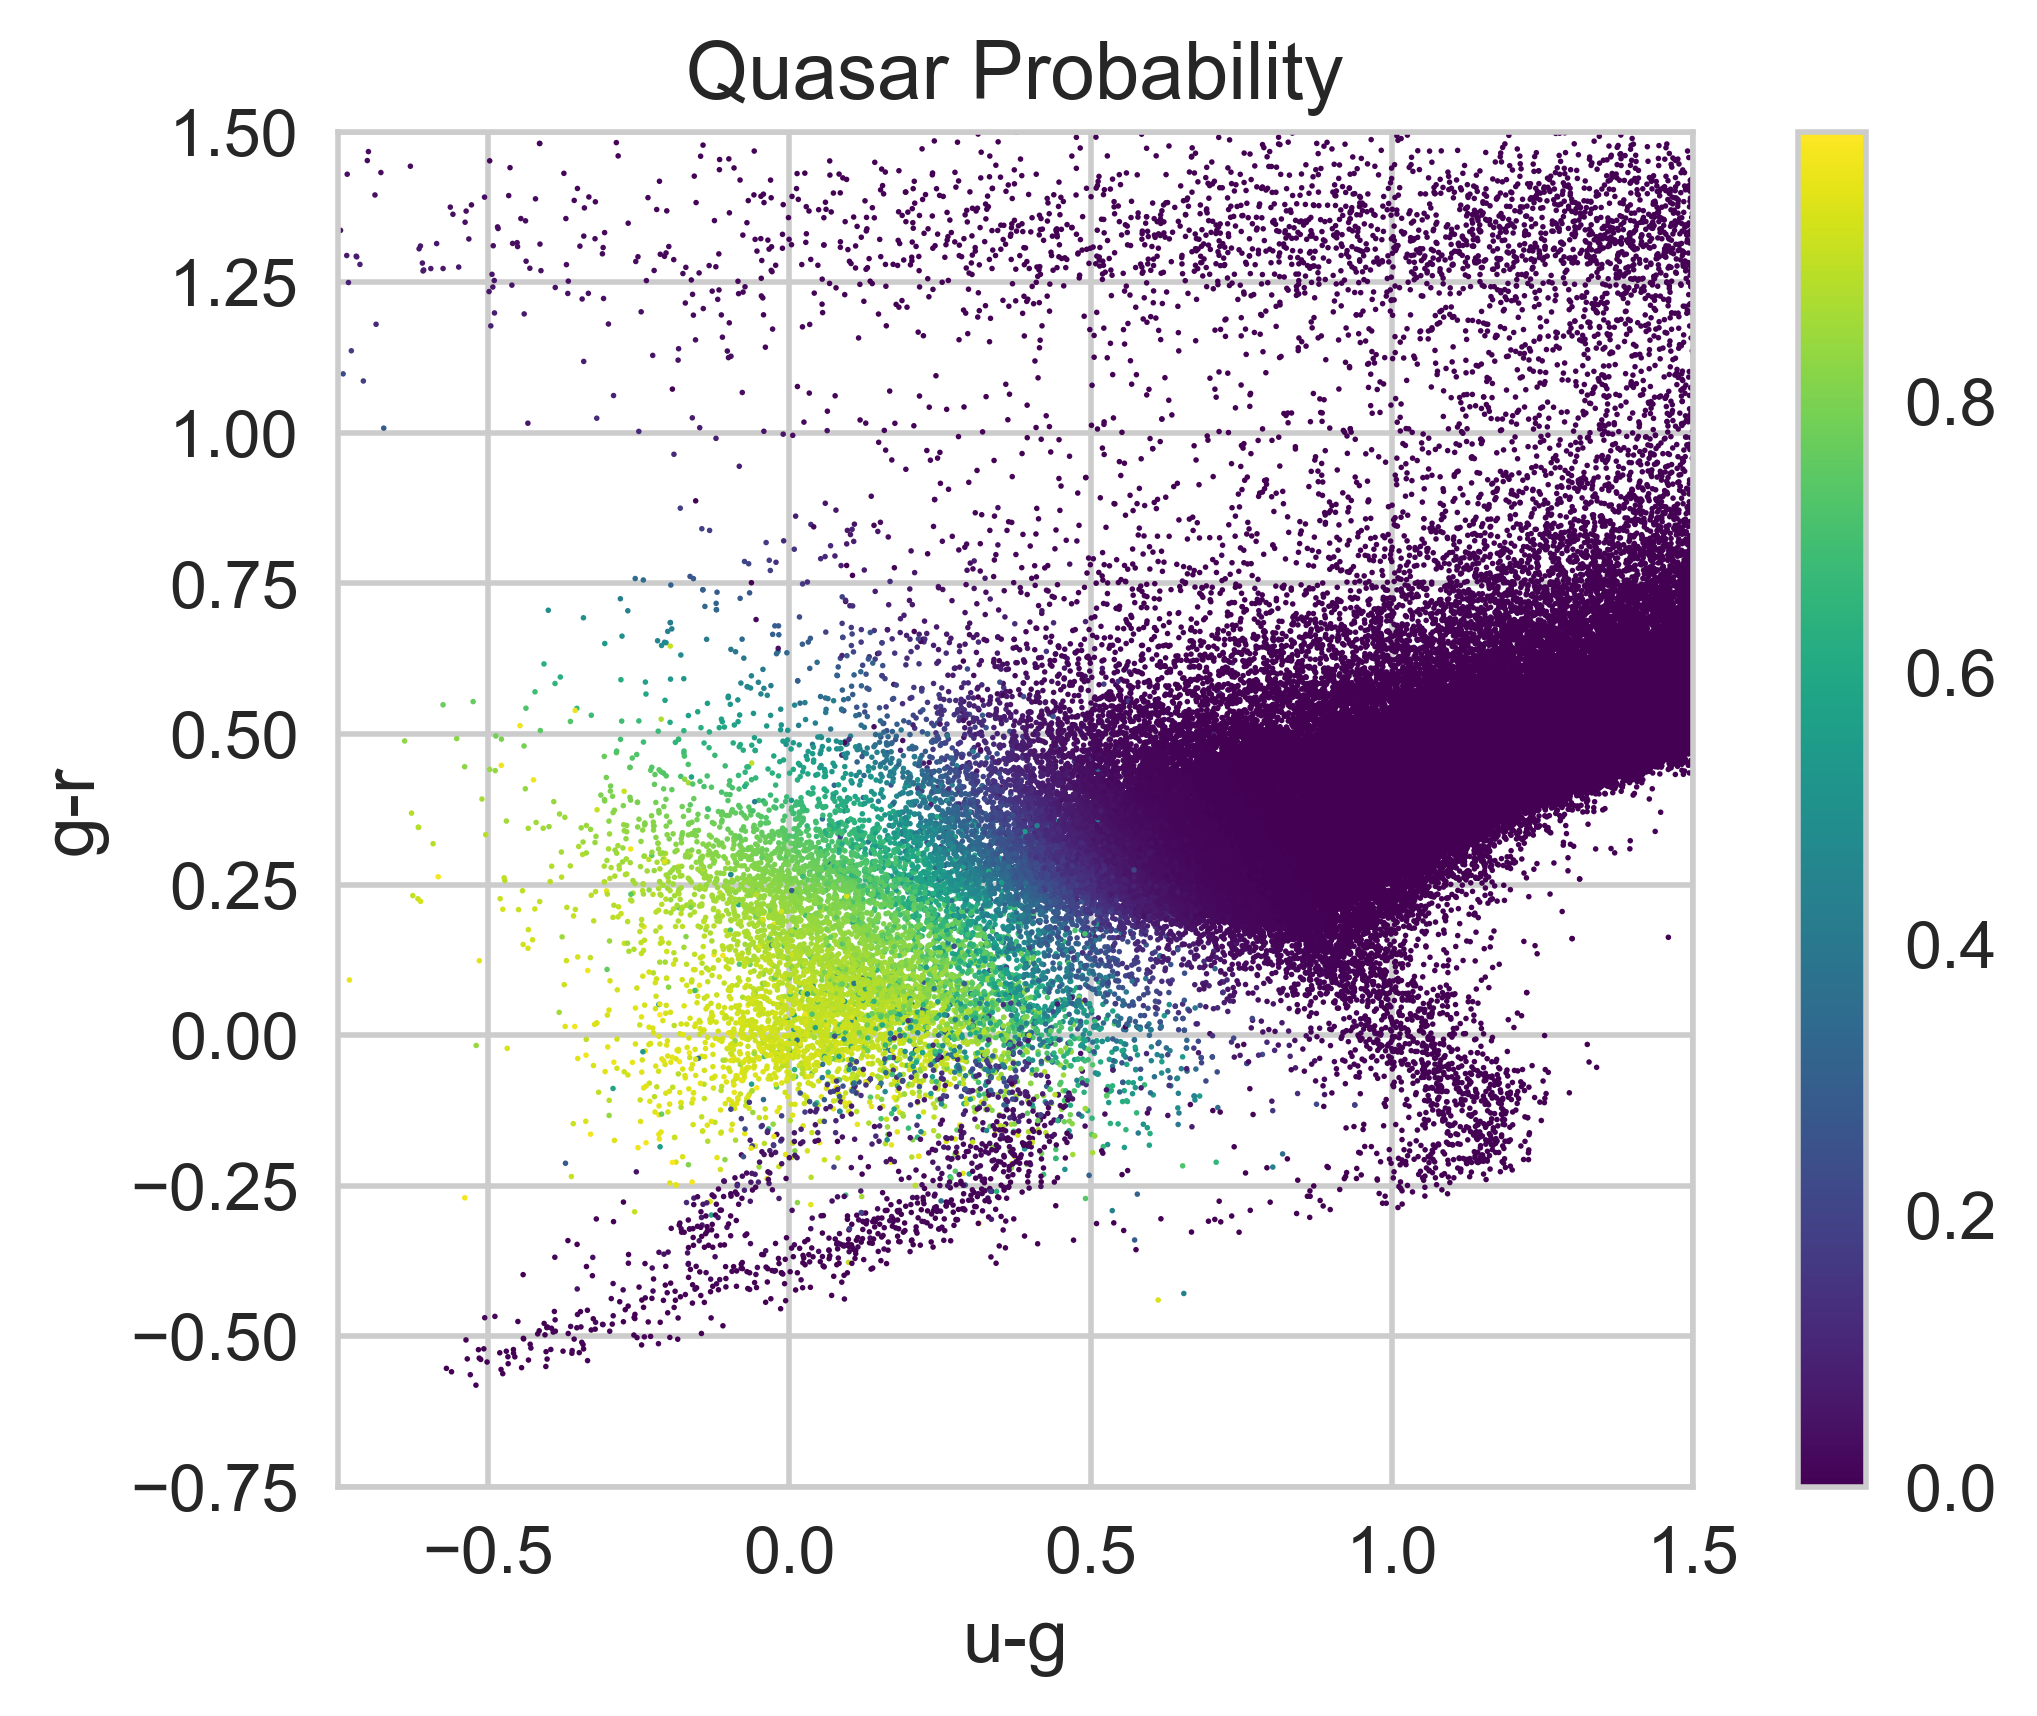

In [38]:
y_pred = model.predict_proba(X, verbose=1)

fig, ax = plt.subplots(1, 1, dpi=200)
fig.tight_layout()
cm = ax.scatter(X[:, 0], X[:, 1], c=y_pred[:, 1], s=1, edgecolors="None", cmap="viridis")
ax.set_xlabel("u-g");
ax.set_ylabel("g-r");
ax.set_aspect("equal");
ax.set_xlim(-0.75, 1.5);
ax.set_ylim(-0.75, 1.5);
ax.set_title("Quasar Probability");
fig.colorbar(cm);

### Six Layers

In [39]:
# Little bit more complicated: two layers: 
# 32 fully interconnected nodes with relu activation x 4
# 16 fully interconnected nodes with relu activation
# 2 fully interconnected nodes with softmax activation

model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(32, input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(32, input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(32, input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(16, input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                160       
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_5 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_6 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
__________

In [40]:
batch_size = 128
nb_epoch = 2

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    nb_epoch=nb_epoch,
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    callbacks=[TQDMNotebookCallback()])
score, accuracy = model.evaluate(X_test, Y_test, verbose=1)
print('Test score: {}; test accuracy: {}'.format(score, accuracy))

Train on 241309 samples, validate on 26813 samples


HBox(children=(IntProgress(value=0, description='Training', max=2), HTML(value='')))

Epoch 1/2


HBox(children=(IntProgress(value=0, description='Epoch 0', max=241309), HTML(value='')))

241309/241309 [==============================] - 6s 26us/step - loss: 0.0335 - acc: 0.9889 - val_loss: 0.0255 - val_acc: 0.9909
Epoch 2/2


HBox(children=(IntProgress(value=0, description='Epoch 1', max=241309), HTML(value='')))

241309/241309 [==============================] - 7s 27us/step - loss: 0.0242 - acc: 0.9914 - val_loss: 0.0255 - val_acc: 0.9909

26813/26813 [==============================] - 1s 23us/step
Test score: 0.025506845655306542; test accuracy: 0.9908999365779121


268122/268122 [==============================] - 4s 16us/step


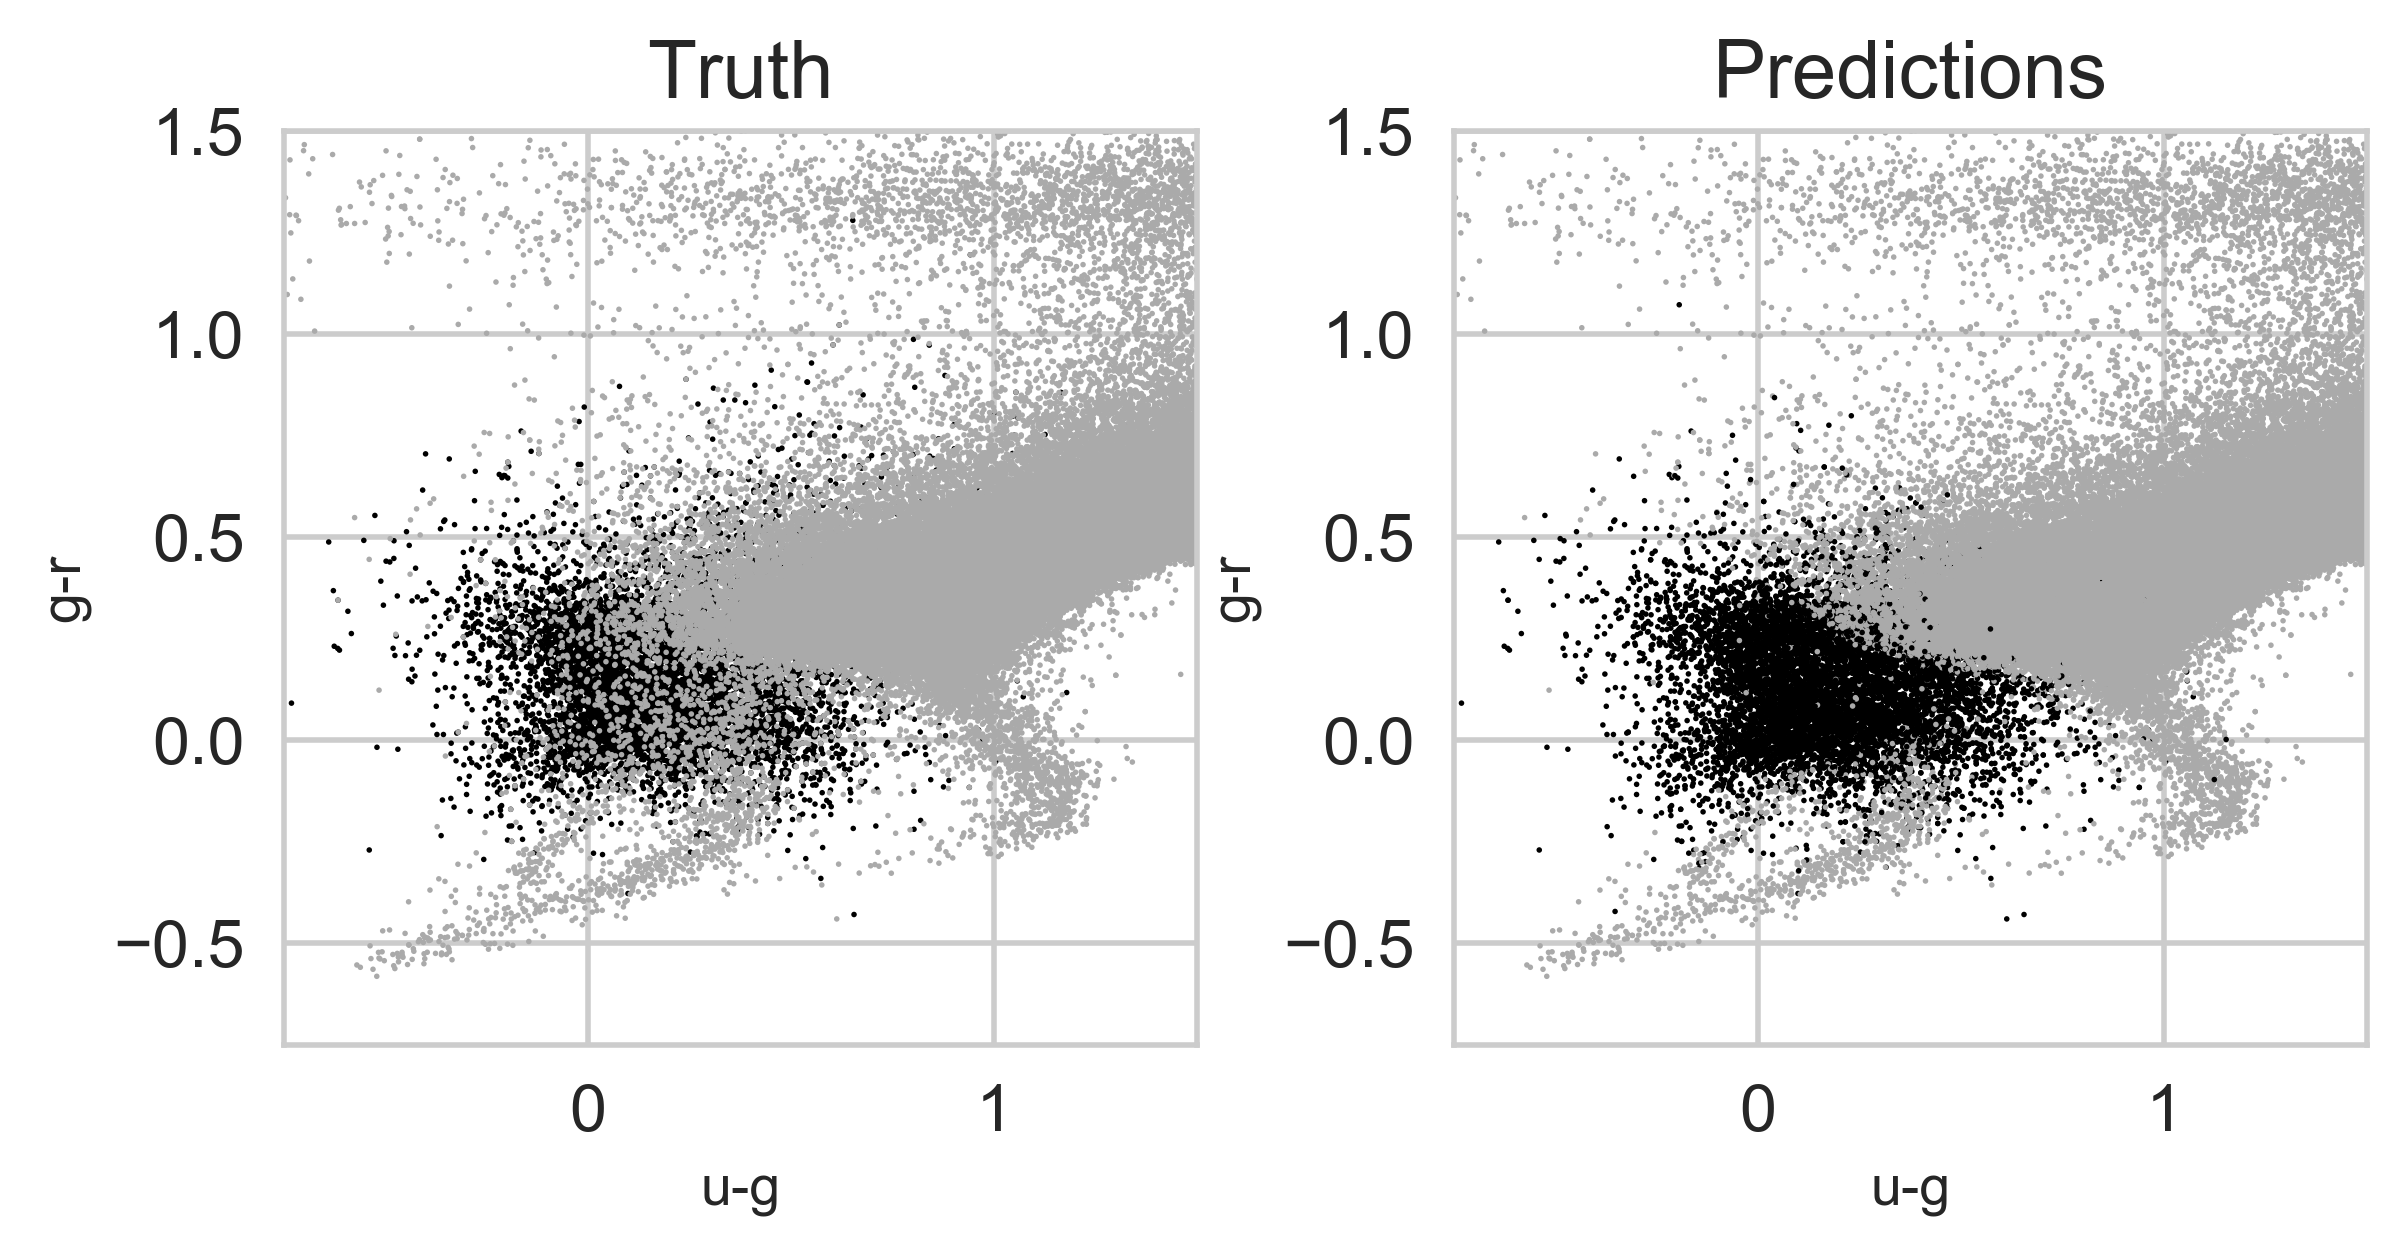

In [41]:
y_pred = model.predict_proba(X)
pred_test = model.predict_classes(X, verbose=1)

fig, ax = plt.subplots(1, 2, dpi=200)
fig.tight_layout()
im = ax[0].scatter(X[:, 0], X[:, 1], c=y, s=1, edgecolors="None",  cmap=plt.cm.binary)
im.set_clim(-0.5, 1)
im = ax[1].scatter(X[:, 0], X[:, 1], c=pred_test, s=1, edgecolors="None", cmap=plt.cm.binary)
im.set_clim(-0.5, 1)

ax[0].set_title("Truth")
ax[1].set_title("Predictions")


for a in ax:
    a.set_xlabel("u-g", size=10);
    a.set_ylabel("g-r", size=10);
    a.set_aspect("equal");
    a.set_xlim(-0.75, 1.5);
    a.set_ylim(-0.75, 1.5);

268122/268122 [==============================] - 4s 14us/step


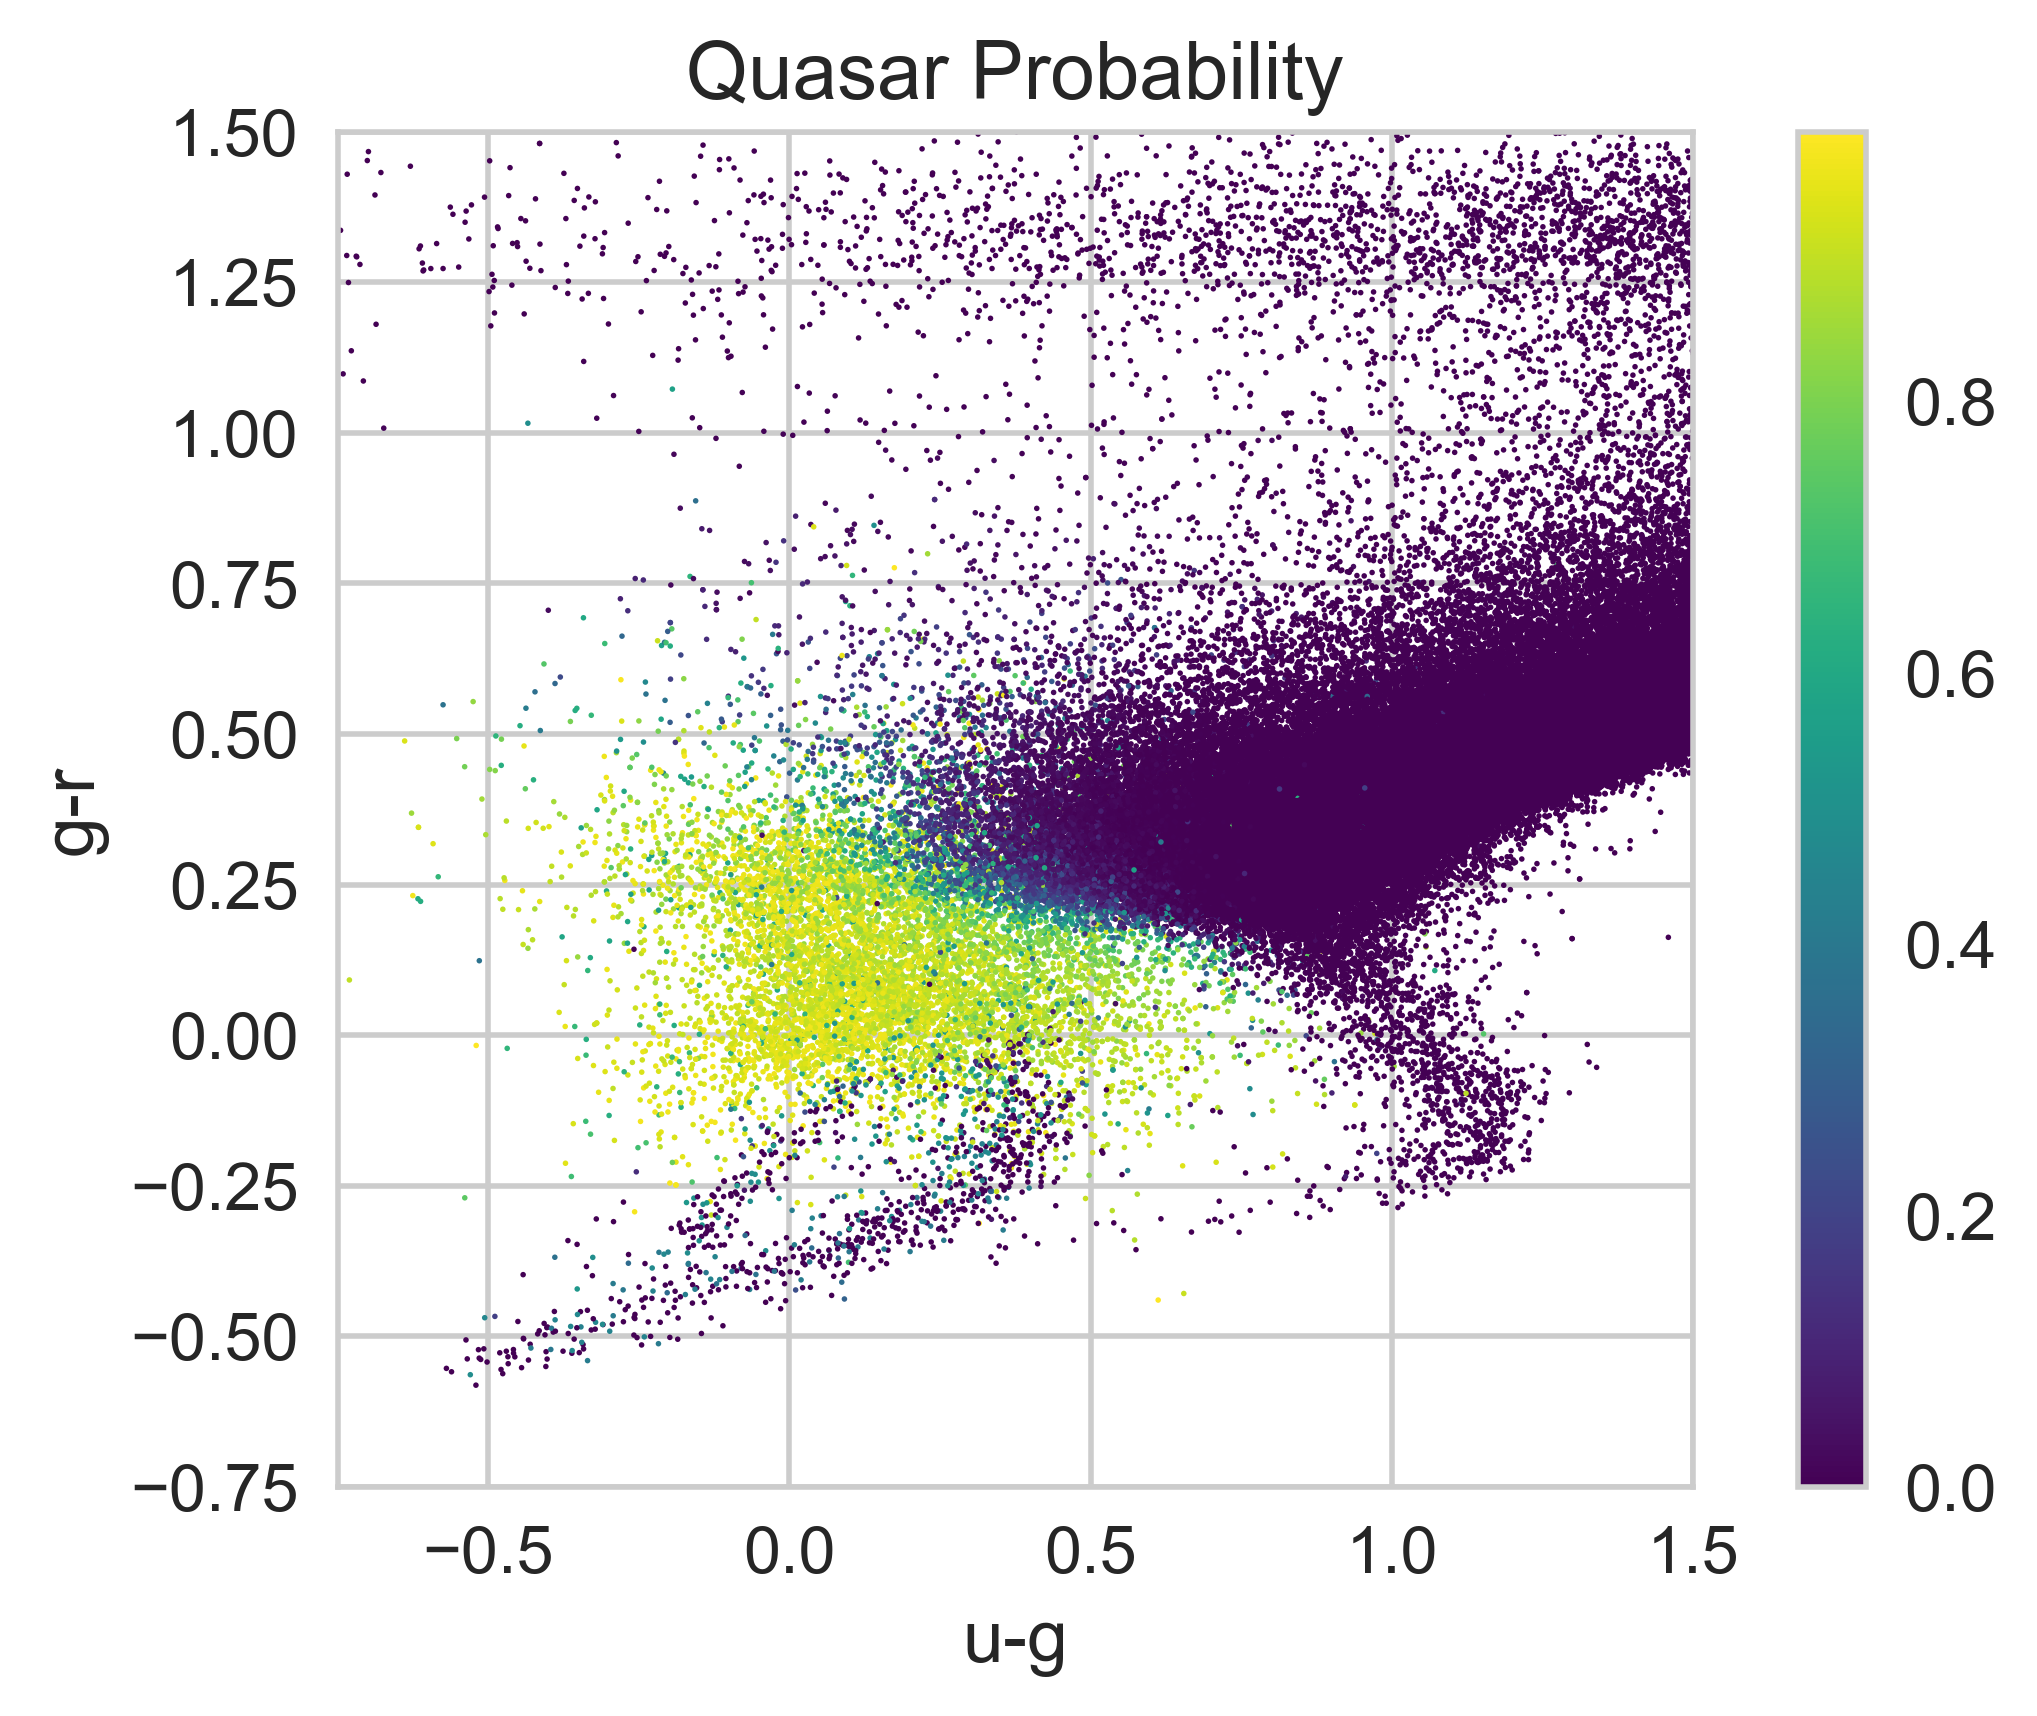

In [42]:
y_pred = model.predict_proba(X, verbose=1)

fig, ax = plt.subplots(1, 1, dpi=200)
fig.tight_layout()
cm = ax.scatter(X[:, 0], X[:, 1], c=y_pred[:, 1], s=1, edgecolors="None", cmap="viridis")
ax.set_xlabel("u-g");
ax.set_ylabel("g-r");
ax.set_aspect("equal");
ax.set_xlim(-0.75, 1.5);
ax.set_ylim(-0.75, 1.5);
ax.set_title("Quasar Probability");
fig.colorbar(cm);